Project 2: Model Engineering
===

___

Submitted by:

* <u>*Arthur Humblot*</u>
* <u>*Bekhzod Anvarov*</u>
* <u>*Ghita El Belghiti*</u>


University: **Politechnico di Torino**

Academic Year: **2025 - 2026**

## 1. Task 1: Frequency-based baseline

In Machine Learning problems, it is always good practice to compare against baseline solutions. Typically, one baseline involves a simple approach that helps determine whether simple choices and assumptions can already address the problem - before progressing to potentially more complex architectures like RNNs or GNNs.

In this context, a suitable baseline is a **frequency-based** approach.

Specifically:

In [1]:
#imports here
import pandas as pd

In [2]:
# read dataset
df_train = pd.read_json("../data/train.json")
df_test = pd.read_json("../data/test.json")

# instruction check
print(df_train.head())
print(df_test.head())

                                   api_call_sequence  is_malware
0  [LdrGetDllHandle, LdrGetProcedureAddress, LdrL...           1
1  [NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...           1
2  [FindResourceExW, LoadResource, FindResourceEx...           1
3  [FindResourceExW, LoadResource, FindResourceEx...           1
4  [LdrGetProcedureAddress, SetErrorMode, LdrLoad...           1
                                   api_call_sequence  is_malware
0  [NtQueryValueKey, NtClose, NtOpenKey, NtQueryV...           1
1  [LdrGetProcedureAddress, NtClose, NtOpenKey, N...           1
2  [NtOpenKey, NtQueryValueKey, NtClose, NtOpenKe...           1
3  [NtAllocateVirtualMemory, LdrLoadDll, LdrGetPr...           1
4  [NtOpenKey, NtQueryValueKey, NtClose, LdrGetPr...           1


* Extract the vocabulary from your input dataset - that is, the **set of all the API calls** appearing in it

In [3]:
# extract sequences(api) and labels
train_seqs = df_train['api_call_sequence'].tolist()
test_seqs = df_test['api_call_sequence'].tolist()

train_labels = df_train['is_malware'].tolist()
test_labels = df_test['is_malware'].tolist()

# instruction check
print(train_seqs[0][:5])
print(f"Type of sequence: {type(train_seqs[0]).__name__}")

['LdrGetDllHandle', 'LdrGetProcedureAddress', 'LdrLoadDll', 'LdrGetProcedureAddress', 'LdrGetDllHandle']
Type of sequence: list


* **Q:** How many unique API calls does the training set contain?

In [4]:
# create train vocabulary unique api
train_vocab = set()

for train_seq in train_seqs:
    for api_call in train_seq:
        train_vocab.add(api_call)

print(f"Number of unique API calls the training set contain: {len(train_vocab)}")

Number of unique API calls the training set contain: 258


And how many the test set?

In [5]:
# create test vocal unique api
test_vocab = set()

for test_seq in test_seqs:
    for api_call in test_seq:
        test_vocab.add(api_call)

print(f"Number of unique API calls the test set contain: {len(test_vocab)}")

Number of unique API calls the test set contain: 232


* **Q:** Are there any API calls that appear only in the test set (but not in the training set)? If yes, how many? And which one are they?

In [6]:
# features, which appear only in test set, and not in train set
only_in_test = test_vocab - train_vocab
print(f"Number of unique API calls only the test set contain(but not in the training set): {len(only_in_test)}")
print(f"Unique API calls only the test set contain:\n{only_in_test}")

Number of unique API calls only the test set contain(but not in the training set): 3
Unique API calls only the test set contain:
{'ControlService', 'NtDeleteKey', 'WSASocketA'}


In [7]:
# sorted vocabulary
train_vocab_sorted = sorted([i for i in train_vocab])
test_vocab_sorted = sorted([i for i in test_vocab])

# instruction check
print(train_vocab_sorted[:5])
print(test_vocab_sorted[:5])

['CertOpenStore', 'CertOpenSystemStoreW', 'CoCreateInstance', 'CoCreateInstanceEx', 'CoGetClassObject']
['CoCreateInstance', 'CoCreateInstanceEx', 'CoGetClassObject', 'CoInitializeEx', 'CoInitializeSecurity']


* **Q:** Can you use the test vocabulary to build the new test dataframe? If not, how do you handle API calls in the test set that do not exist in the training vocabulary?

In [8]:
feature_names = train_vocab_sorted + ['<UNK>']

We add **< UNK >** - for features unknown for train set and appears on test set only

* Use this vocabulary as the **feature set**: for each row in the input dataset, count the **number of times** (frequency) each vocabulary term occurs

In [9]:
# map api with their positions
api_to_idx = dict()

for i in range(len(feature_names)):
    api_to_idx[feature_names[i]] = i

# creating features for train
X_train = list()

for seq in train_seqs:
    freq = [0 for _ in range(len(feature_names))]   # frequency vector for train features
    for api_call in seq:
        if api_call in api_to_idx:
            freq[api_to_idx[api_call]] += 1
    X_train.append(freq)

# creating features for train
X_test = list()

for seq in test_seqs:
    freq = [0 for _ in range(len(feature_names))]   # frequency vector for test features
    for api_call in seq:
        if api_call in api_to_idx:
            freq[api_to_idx[api_call]] += 1     # UNK features, which are only on test
        else:
            freq[-1] += 1
    X_test.append(freq)

* **Q:** One issue of this frequency-based approach is that it creates sparse vectors (i.e., vectors with many zeros per row):
    * how many non-zero elements per row do you have on average in the training set?
    * How many in the test set ?
    * What is the ratio with respect to the number of elements per row?

In [10]:
# sparsity for the train set (non-zero per row)
nnz_train_per_row = list()  # num of non zeros

for freq in X_train:
    nnz_train_per_row.append(sum([1 if i > 0 else 0 for i in freq]))

avg_non_zero_train = sum(nnz_train_per_row) / len(X_train)
print(f"Average non-zero elements per row in training set: {avg_non_zero_train:.2f}")
ratio_train = avg_non_zero_train / len(feature_names)
print(f"Ratio with respect to the number of elements per row in training set: {ratio_train:.2f}\n")


# sparsity for the test set (non-zero per row)
nnz_test_per_row = list()  # num of non zeros

for freq in X_test:
    nnz_test_per_row.append(sum([1 if i > 0 else 0 for i in freq]))

avg_non_zero_test = sum(nnz_test_per_row) / len(X_test)
print(f"Average non-zero elements per row in test set: {avg_non_zero_test:.2f}")
ratio_test = avg_non_zero_test / len(feature_names)
print(f"Ratio with respect to the number of elements per row in test set: {ratio_test:.2f}")

Average non-zero elements per row in training set: 21.95
Ratio with respect to the number of elements per row in training set: 0.08

Average non-zero elements per row in test set: 24.28
Ratio with respect to the number of elements per row in test set: 0.09


⬇️⬇️⬇️This is HELPER NOT PART OF TASK ⬇️⬇️⬇️

In [11]:
""" This is temporary helper which is not part of lab activity !!! """

# ---------- Reused across Task 1–4 (keep these) ----------

"""
    df_train: pandas DataFrame for training data loaded from train.json
    df_test: pandas DataFrame for test data loaded from test.json

    train_seqs: list of lists, each inner list is a sequence of API call strings from the training set
    test_seqs: list of lists, each inner list is a sequence of API call strings from the test set

    y_train: list/array of labels (0 = goodware, 1 = malware) for training samples
    y_test: list/array of labels (0 = goodware, 1 = malware) for test samples

    train_vocab: set of unique API call strings observed in the training set
    test_vocab: set of unique API call strings observed in the test set (used for analysis / OOV check)

    train_vocab_sorted: sorted list of API call strings from train_vocab
    feature_names: list of feature names for Task 1 (train_vocab_sorted + ['<UNK>'])
                  later tasks may use a similar list for building ID/embedding vocabularies

    api_to_idx: dictionary mapping API call string -> integer index
          (for Task 1: column index in the frequency vector;
          for Tasks 2–3 you will build a similar mapping for IDs/embeddings)

    only_test: set of API call strings that appear only in test (test_vocab - train_vocab)
        used to motivate the need for an <UNK> token / index
"""

"\n    df_train: pandas DataFrame for training data loaded from train.json\n    df_test: pandas DataFrame for test data loaded from test.json\n\n    train_seqs: list of lists, each inner list is a sequence of API call strings from the training set\n    test_seqs: list of lists, each inner list is a sequence of API call strings from the test set\n\n    y_train: list/array of labels (0 = goodware, 1 = malware) for training samples\n    y_test: list/array of labels (0 = goodware, 1 = malware) for test samples\n\n    train_vocab: set of unique API call strings observed in the training set\n    test_vocab: set of unique API call strings observed in the test set (used for analysis / OOV check)\n\n    train_vocab_sorted: sorted list of API call strings from train_vocab\n    feature_names: list of feature names for Task 1 (train_vocab_sorted + ['<UNK>'])\n                  later tasks may use a similar list for building ID/embedding vocabularies\n\n    api_to_idx: dictionary mapping API call s

## 2. Task 2: Feed Forward Neural Network (FFNN)

## 3. Task 3: Recurrent Neural Network (RNN)

## 4. Task 4: Graph Neural Network (GNN)

* **Q**: Do you still have to pad your data? If yes, how?

We don’t need padding because the inputs of a GNN are graphs, which can have different sizes. However, the dataset still requires some preprocessing to be transformed into graph form, as seen in the course: each API sequence must be converted into nodes, the transitions between APIs into edges, and node features must be constructed for each graph.

* **Q**: Do you have to truncate the testing sequences? Justify your answer with your understanding of why it is/it is not the case.

No, we don’t need to truncate the testing sequences. As we saw in the lectures, a GNN works on graphs, and each sequence is transformed into a graph where each API call is a node and edges represent the transitions between them. Since graphs can have different numbers of nodes, the network can handle sequences of varying lengths. Truncating the sequences would actually remove some information, which could be important for the model to detect malware patterns. So, we can keep the testing sequences complete without any truncation.

* **Q**:What is the advantage of modeling your problem with a GNN with respect to an RNN in this scenario? However, what do you lose?
  
Using a GNN in this scenario has the advantage that it can model the API calls as a graph, which allows the network to capture the structural relationships between calls, including loops and non‑linear dependencies. This is something an RNN struggles with, since an RNN only processes the sequence in order and mainly focuses on temporal relationships. However, the downside of using a GNN is that we lose some of the explicit sequential information. A GNN does not naturally preserve the exact temporal order of the calls it mostly sees which nodes are connected, not how many steps separate them. Another issue we discussed is that if an attacker obfuscates a malware by inserting many useless API calls between two important ones, the GNN might have a harder time noticing the link between those key calls. Because the graph gets larger and filled with “noise” nodes, the important transitions can become diluted inside the structure. An RNN, on the other hand, keeps the full order of the sequence, so it may be more sensitive to such obfuscation patterns.



 * **Q**:Finally train and tune variations of GNN considering different message and aggregation
 functions and architectures:– Simple GCN– GraphSAGE– and GAT

Let's begging by formating the data


In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


class GraphDataset(Dataset):
    def __init__(self, adj_matrices, features, labels, transform=None):
        super().__init__(transform)
        self.graphs = []

        for i in range(len(adj_matrices)):
            # Edge index (2 x num_edges)
            row, col = np.where(adj_matrices[i] == 1)
            edge_index = torch.from_numpy(np.vstack((row, col))).long()

            # Node features
            x = torch.tensor(features[i], dtype=torch.float)

            # Convert One-Hot to indices if needed
            if x.dim() == 2 and x.size(1) > 1:
                x = torch.argmax(x, dim=1).long()

            # Graph label
            y = torch.tensor(labels[i], dtype=torch.long)

            self.graphs.append(Data(x=x, edge_index=edge_index, y=y))

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]




In [13]:
# Train vocabulary from Task1
random_seed = 42
feature_names = train_vocab_sorted + ['<UNK>']
api_to_id = {api: idx for idx, api in enumerate(sorted(feature_names))}

# Split train into train + validation (e.g., 80% train, 20% val)
df_train_split, df_val_split = train_test_split(df_train, test_size=0.2, random_state=random_seed, stratify=df_train['is_malware'])

import numpy as np

def build_graph_data(df, api_to_id, add_self_loops=True):
    """
    Converts a DataFrame containing sequences of API calls into graphs
    compatible with PyTorch Geometric (integer labels for CrossEntropyLoss).
    
    Args:
        df (pd.DataFrame): must contain 'api_call_sequence' and 'is_malware'.
        api_to_id (dict): mapping API -> index for the global one-hot encoding.
        add_self_loops (bool): if True, self-loops are added to each graph.
    
    Returns:
        adj_matrices (list[np.ndarray]): adjacency matrices for each graph.
        features (list[np.ndarray]): feature matrices for each graph.
        labels (list[int]): integer labels corresponding to malware/benign.
    """
    adj_matrices = []
    features = []
    labels = []

    for _, row in df.iterrows():
        seq = row["api_call_sequence"]
        label = int(row["is_malware"])  # 0 ou 1

        node_count = len(seq)
        feat_size = len(api_to_id)

        # Build adjacency matrix, connect each API call to the next
        adj = np.zeros((node_count, node_count), dtype=np.int8)
        for i in range(node_count - 1):
            adj[i, i + 1] = 1

        # Optional self-loops to allow nodes to keep their own state
        if add_self_loops:
            np.fill_diagonal(adj, 1)

        # One-hot encoding for each API call; unknown calls map to "<UNK>"
        feat = np.zeros((node_count, feat_size), dtype=np.float32)
        for i, api in enumerate(seq):
            idx = api_to_id.get(api, api_to_id.get("<UNK>", 0))
            feat[i, idx] = 1

        # Store graph data
        adj_matrices.append(adj)
        features.append(feat)
        labels.append(label)

    #Here to see the distribution
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Distribution of labels in this DataFrame : {distribution}")

    return adj_matrices, features, labels

train_adj, train_feat, train_labels = build_graph_data(df_train_split, api_to_id)
val_adj, val_feat, val_labels = build_graph_data(df_val_split, api_to_id)
test_adj, test_feat, test_labels = build_graph_data(df_test, api_to_id)

# Compute class weights based on label distribution
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
total_samples = sum(class_counts)

class_weights = [total_samples / c for c in class_counts]  # inverse frequency
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights:", class_weights)


train_dataset = GraphDataset(train_adj, train_feat, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = GraphDataset(test_adj, test_feat, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

val_dataset = GraphDataset(val_adj, val_feat, val_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Distribution des labels dans ce DataFrame : {np.int64(0): np.int64(489), np.int64(1): np.int64(12571)}
Distribution des labels dans ce DataFrame : {np.int64(0): np.int64(122), np.int64(1): np.int64(3143)}
Distribution des labels dans ce DataFrame : {np.int64(0): np.int64(243), np.int64(1): np.int64(6262)}
Class weights: tensor([26.7076,  1.0389])


The dataset contains far more samples labeled as malware than benign, which creates a strong class imbalance that can bias the model toward the majority class and reduce its ability to correctly detect the minority class. Although one might think prioritizing malware detection is safer, a model that flags too many benign programs as malicious would severely disrupt normal computer use, so achieving a balanced performance across both classes is more important than maximizing overall accurac herey, which makes accuracy alone a poor indicator in our case.

* **Q**: How does each model perform with respect to the previous architectures? Can you
beat the baseline?

When designing our GNN-based malware detection system, we initially implemented a baseline architecture inspired by the course materials: a simple one-hot node representation, no weight decay, and no class weighting. Although this first model exhibited an apparently excellent global accuracy of around 98%, this metric turned out to be misleading, since it almost completely ignored the minority class. Because malicious behaviors represent a very small proportion of the dataset, the classifier could achieve high accuracy simply by predicting the majority (benign) class. This is unacceptable for a security-oriented model, since our objective is to correctly detect malicious executions at all costs while avoiding excessive false positives impacting legitimate users. To address this imbalance, we first introduced class weights into the loss function, forcing the model to learn minority samples. This significantly improved detection rates, raising minority-class recall between 75% and 90%, especially with the GAT model, despite an overall accuracy closer to 80%.

However, all three architectures (GCN, GraphSAGE, and GAT) quickly suffered from severe overfitting, with validation loss rising after just a few epochs. We experimented with several mitigation strategies: reducing the hidden dimensionality (effective below 16, but leading to large performance loss), adding weight decay regularization, and replacing one-hot node encoding with an embedding layer. The latter compresses node information into a continuous latent space (reduced from 250 to 64 dimensions), allowing the network to focus on meaningful semantic patterns while discarding noise. This combination of embedding and regularization dramatically reduced overfitting and even improved performance for GCN and GraphSAGE. Training for more epochs brings little benefit and mainly increases overfitting, causing the model to memorize the data instead of learning to generalize. Although GAT showed a decrease in performance after these changes, potentially due to tuning issues ( he now value the minority class too much), our best results were finally obtained with the: GrapheSAGE. The most effective way to improve the model further would be to acquire a larger and better-balanced dataset, as no algorithmic adjustment can fully compensate for an extreme class imbalance.





In [14]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_types, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super(GCN, self).__init__()
        self.embedding = torch.nn.Embedding(num_node_types, embed_dim)
        self.conv1 = GCNConv(embed_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
   
    def forward(self, data):
        x = self.embedding(data.x)
        edge_index, batch = data.edge_index, data.batch
        
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_types, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.embedding = torch.nn.Embedding(num_node_types, embed_dim)
        self.conv1 = SAGEConv(embed_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = self.embedding(data.x)
        edge_index, batch = data.edge_index, data.batch
        
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

class GAT(torch.nn.Module):
    def __init__(self, num_node_types, embed_dim, hidden_dim, output_dim, heads=2, dropout=0.6):
        super(GAT, self).__init__()
        self.embedding = torch.nn.Embedding(num_node_types, embed_dim)
        self.dropout_layer = torch.nn.Dropout(dropout)
        self.conv1 = GATConv(embed_dim, hidden_dim, heads=heads, concat=True, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = self.embedding(data.x)
        edge_index, batch = data.edge_index, data.batch
        
        x = self.dropout_layer(x)
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout_layer(x)
        
        x = F.elu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        
        x = self.fc(x)
        return x



In [15]:
# Function to visualize model performance by creating a confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name, model_name):
    """
    Creates and displays a confusion matrix to evaluate classification performance.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of class names for axis labels
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix +" +dataset_name+ " "+ model_name)
    plt.show()

def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.
    
    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.
    
    Returns:
        None: The function plots the training and validation loss over the epochs.
    """
    

    # Record the start time
    start_time = time.time()


    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode       
        for batch in train_loader:
            batch = batch.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch)  # Forward pass           
            loss = criterion(outputs, batch.y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                batch = batch.to(device)  # Move batch to GPU
                val_outputs = model(batch)  # Forward pass
                
                loss = criterion(val_outputs, batch.y)  # Compute validation loss. .squeeze() is used to reduce from 2D to 1D vector
                val_loss += loss.item() * batch.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss        
            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

            
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
            
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
        
    return

def testing_model(model, dataloader, device, dataset_name, model_name):
    """
    Evaluate the model on a given dataloader and compute accuracy.
    
    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """
    start_time = time.time()
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)  # Get class with highest score

            # Flatten labels to 1D to avoid 0-d array issues
            all_labels.extend(batch.y.view(-1).cpu().numpy())
            all_predictions.extend(predicted.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Class names
    class_names = [f"Class {cls}" for cls in np.unique(all_labels)]

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_predictions, class_names, dataset_name, model_name)

    elapsed_time = time.time() - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy

cpu
Epoch 20/50, Train Loss: 33.8175, Val Loss: 32.2675
Epoch 40/50, Train Loss: 28.7022, Val Loss: 28.5535
The function took 217.2637 seconds to execute.


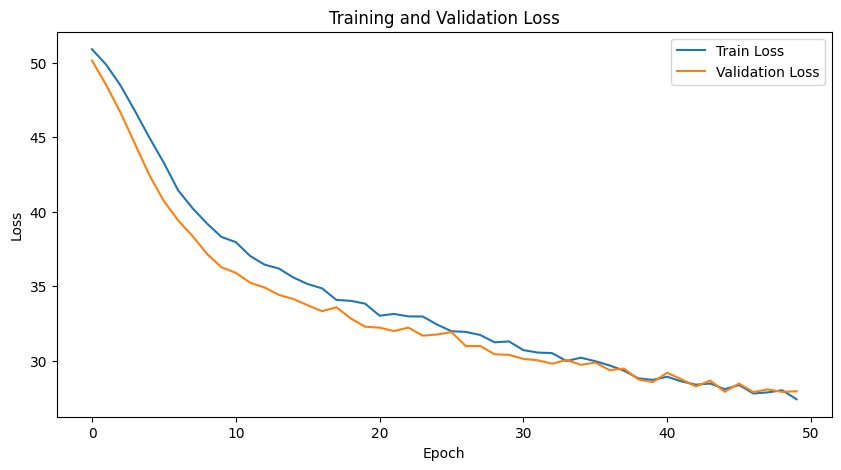

Epoch 20/50, Train Loss: 31.7939, Val Loss: 30.3490
Epoch 40/50, Train Loss: 27.1188, Val Loss: 28.0381
The function took 229.0153 seconds to execute.


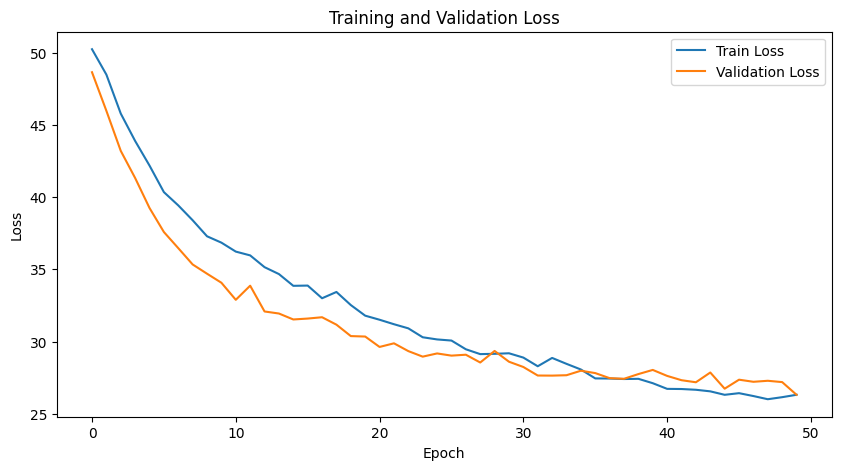

Epoch 20/50, Train Loss: 38.4743, Val Loss: 42.6757
Epoch 40/50, Train Loss: 35.9828, Val Loss: 41.8746
The function took 590.8850 seconds to execute.


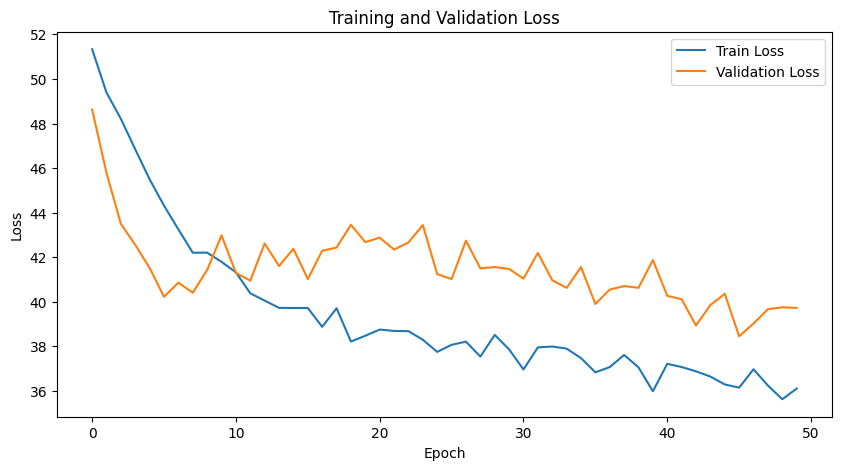

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 50
learning_rate = 0.0001
weight_decay = 1e-4
embed_dim = 64
hidden_dim = 64
output_dim = 2
num_node_types = len(api_to_id)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# GCN
GCNmodel = GCN(num_node_types, embed_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(GCNmodel.parameters(), lr=learning_rate, weight_decay=weight_decay)
training_loop(GCNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

# GraphSAGE
GraphSAGEmodel = GraphSAGE(num_node_types, embed_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(GraphSAGEmodel.parameters(), lr=learning_rate, weight_decay=weight_decay)
training_loop(GraphSAGEmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

# GAT
GATmodel = GAT(num_node_types, embed_dim, hidden_dim, output_dim, heads=4).to(device)
optimizer = optim.Adam(GATmodel.parameters(), lr=learning_rate, weight_decay=weight_decay)
training_loop(GATmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)



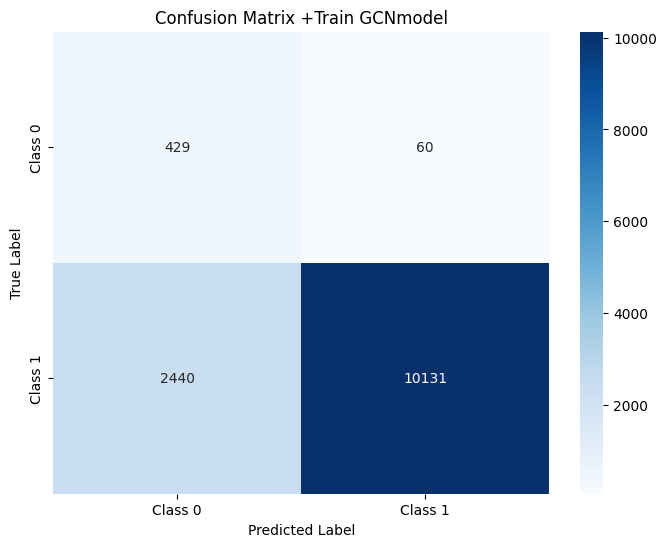

The function took 1.2108 seconds to execute.
Train Accuracy: 80.8576


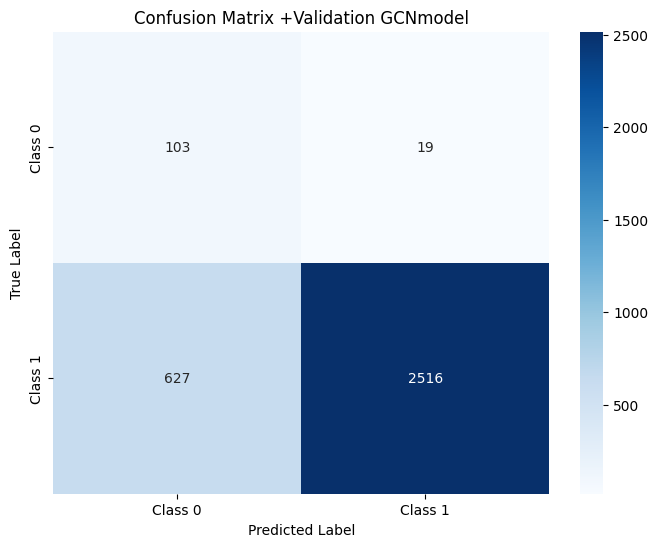

The function took 0.3157 seconds to execute.
Validation Accuracy: 80.2144


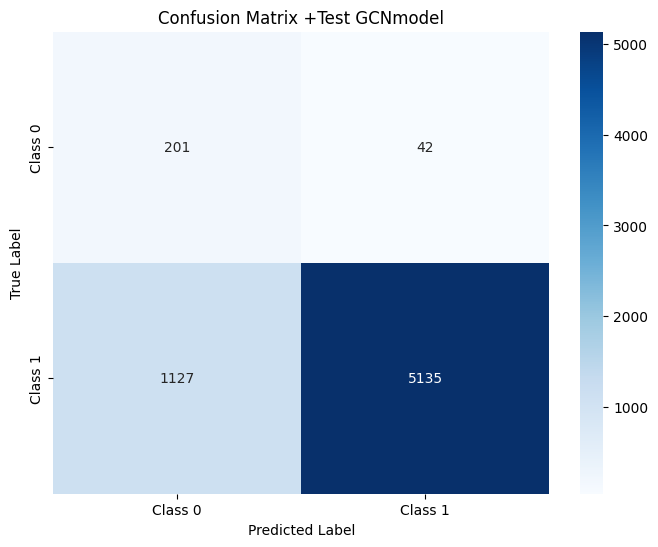

The function took 0.7945 seconds to execute.
Test Accuracy: 82.0292


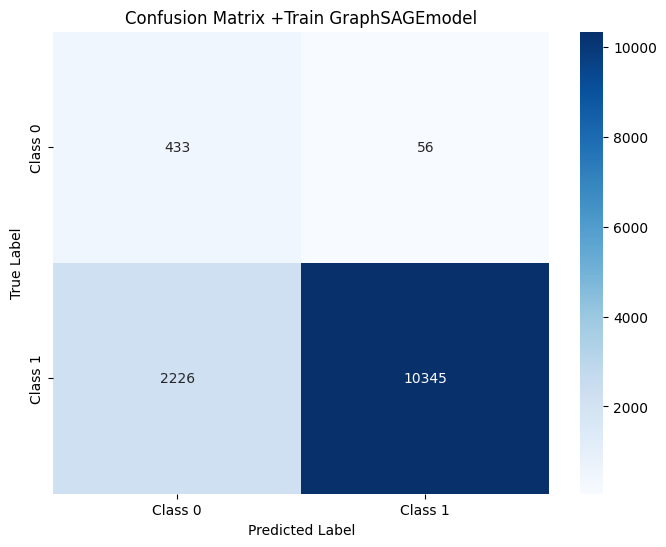

The function took 1.0262 seconds to execute.
Train Accuracy: 82.5268


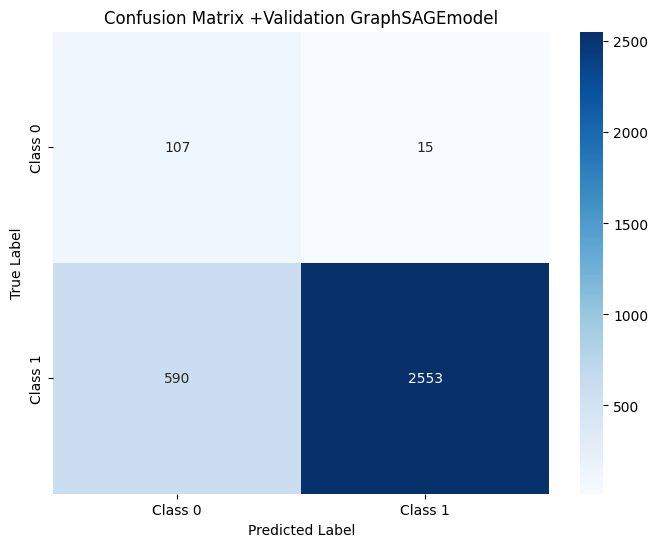

The function took 0.3386 seconds to execute.
Validation Accuracy: 81.4701


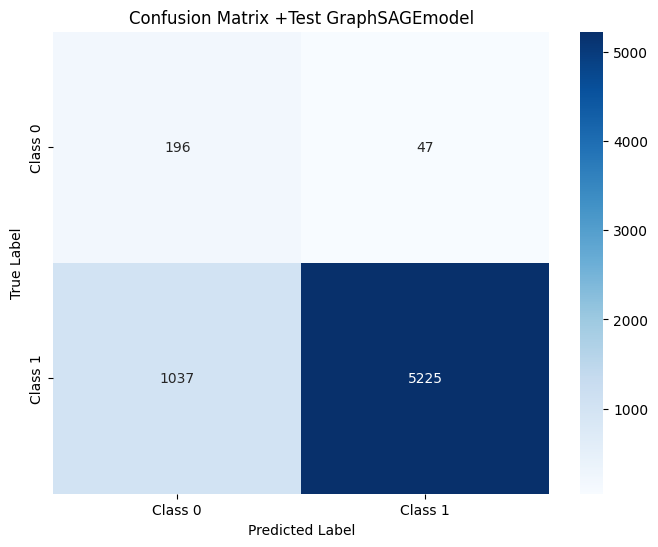

The function took 0.5734 seconds to execute.
Test Accuracy: 83.3359


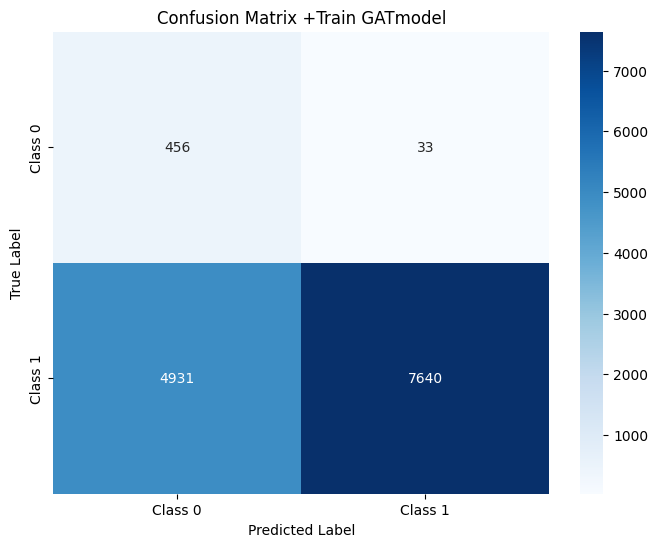

The function took 2.8151 seconds to execute.
Train Accuracy: 61.9908


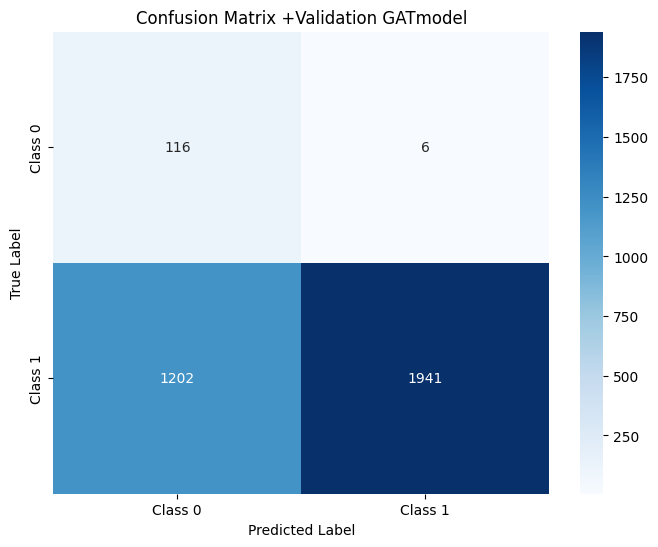

The function took 0.8254 seconds to execute.
Validation Accuracy: 63.0015


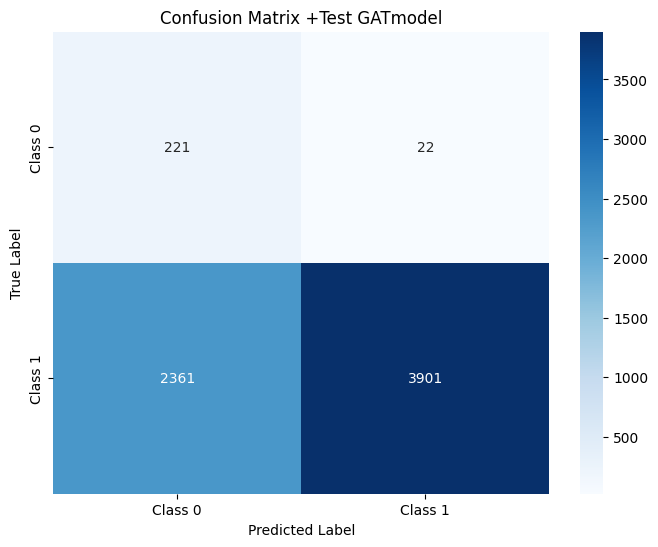

The function took 1.5719 seconds to execute.
Test Accuracy: 63.3666


In [19]:
model_names = ["GCNmodel", "GraphSAGEmodel", "GATmodel"]
models = [GCNmodel, GraphSAGEmodel, GATmodel]
for i in range(len(model_names)):
    model = models[i]
    train_accuracy = testing_model(model, train_loader, device, "Train", model_names[i])
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model(model, val_loader, device, "Validation", model_names[i])
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    test_accuracy = testing_model(model, test_loader, device, "Test", model_names[i])
    print(f'Test Accuracy: {test_accuracy:.4f}')
